***

## **SÃ©bastien DAVID**

## **MS Telecom Big Data | MDI343 Machine Learning**

## **Data Challenge | Fusion of Face Recognition Algorithms**

### February 2020

***

<br>

<p align="center">
  <img src="https://media.boingboing.net/wp-content/uploads/2018/11/T-800a_Positive_ID.jpg"  width="550" height="270"/>
</p>

<br>

**Objective**:
- From a set of image features and the output of different face recognition algorithms, compare a pair of images and decide *whether two images belong to the same person*.

**Abstract**:
- This Jupyter Notebook - which ran on Google Colaboratory with GPU Runtime - contains my solution for MDI343 Course's Data Challenge competition on the blending of face recognition algorithms.
- To summarize, I trained 3 *Extreme Gradient Boosting* algorithms (**XGBoost, LightGBM, CatBoost**) with a holdout validation strategy. Those algorithms are well suited for big data datasets and have achieved widespread popularity on Kaggle competitions dealing with tabular datasets. The predictions of all 3 algorithms were then blended with a stacking strategy, which did increase my leaderboard performance.
- Due to the size of the training dataset and inevitable RAM limitations on Google Colaboratory, feature engineering was limited to adding **absolute differences** between image features and between the outputs of different face recognition algorithms.
- Metric used is the ROC Curve's **True Positive Ratio (TPR) if the maximum tolerated False Positive Ratio (FPR) is set at $10^{-4}$**. This can be interpreted as followed: every 1000 face recognition matches, the worst case we can accept from our classifier is 1 mistake. Basically, we want extreme precision: mistakes should be extremely rare anomalies.
- Definite Testing Set Performance: **88.38%** (TPR)

**Environment**:

- Google Colaboratory's GPU Runtime (with extended 25 GB of RAM) which provides 1 Tesla K80 GPU Machine
- Note that this Colab Notebook was not executed in continuous order as the long running time of many algorithms and **frequent** RAM crashes forced me to execute different cells at different moments

# **Table of Contents**

***

1. [Feature Engineering](#feature)
2. [Exploratory Data Analysis](#eda)
3. [Model Training](#models)
  1. [XGBoost](#xgb)
  2. [LightGBM](#lgb)
  3. [CatBoost](#cbt)
  4. [Stacking](#stacked)
4. [Testing Set Predictions](#test)
5. [Bonus: Machine Learning Interpretability with SHAP](#shap)
6. [Conclusion](#conclusion)

# **Setup**

***

**Download LightGBM with GPU Capabilities**

*Note: XGBoost and CatBoost don't require any setup. Only need to tell both algorithms to run on GPU mode.*

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
%cd build
!cmake ../../LightGBM
!make -j4
!git clone --recursive https://github.com/Microsoft/LightGBM.git
%cd LightGBM/python-package
!python3 setup.py install --gpu

**Packages**

In [ ]:
!pip install catboost
!pip install shap

In [ ]:
# Basic Packages
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import joblib
import pickle
from copy import copy
from pprint import pprint
from IPython.display import clear_output
plt.style.use('fivethirtyeight')

# Exploratory Data Analysis
from sklearn.decomposition import PCA
from sklearn.utils import resample

# Feature Engineering
import itertools
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, QuantileTransformer

# Model Training
import xgboost as xgb
import lightgbm as lgb
import catboost as cbt

# Model Stacking
from sklearn.linear_model import LogisticRegression

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, \
                            average_precision_score, recall_score, \
                            precision_score, f1_score
from sklearn.utils import resample

# Machine Learning Interpretability
import shap

# Global Variables
RANDOM_STATE = 1805

**Load data from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
PATH_TO_FOLDER = '/content/drive/My Drive/TELECOM_MS_BIG_DATA/COURSES/' + \
                 'ADVANCED MACHINE LEARNING/DATA_CHALLENGE_1'
os.chdir(PATH_TO_FOLDER)

In [6]:
%%time
train_data = pd.read_csv('DATA/xtrain_challenge.csv')
train_labels = pd.read_csv('DATA/ytrain_challenge.csv')
test_data = pd.read_csv('DATA/xtest_challenge.csv')

CPU times: user 44 s, sys: 6.87 s, total: 50.8 s
Wall time: 57 s


In [8]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)

(9800713, 37)
(9800713, 1)
(3768311, 37)


**Utilities**

- Memory reduction
- Performance graphs suited for binary classification problems:
  - Lift curve
  - ROC AUC Curve
  - Precision-Recall Curve
  - Optimal Classification Threshold

In [ ]:
class MemoryReductionTransformer(BaseEstimator, TransformerMixin):
    """ Reduces memory usage by iterating over every DataFrame column
    and chaning data type (e.g. float64 -> float16)
    """
    def __init__(self):
        pass

    def reduce_mem_usage(self, df):
        """ Iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.

            Authors:
            - https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
            - https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
        """
        start_mem = df.memory_usage().sum() / 1024**2

        for col in df.columns:
            col_type = df[col].dtype
            
            # print(col, col_type, col_type != object,
            # col_type.name != pd.CategoricalDtype())
            if (col_type == object):
                df[col] = df[col].astype('category')
            # elif (col_type.name == pd.CategoricalDtype()):
            #    pass
            else:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

        end_mem = df.memory_usage().sum() / 1024**2
        return df

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_reduced_memory = self.reduce_mem_usage(X)
        return X_reduced_memory

def plot_lift_curve(y_true, y_prob, model_name, ax):
    """ Lift Curve """
    # Construct Lift Curve
    df = pd.DataFrame(np.array([y_true, y_prob]).T,columns=['true','soft'])
    df.sort_values(by='soft',ascending=False,inplace=True)
    lift = pd.concat([df.groupby('soft').count(),df.groupby('soft').sum()],axis=1)
    lift.sort_index(ascending=False,inplace=True)
    lift.columns = ['strate size','positive']
    lift['negative'] = lift['strate size'] - lift['positive']
    n_positive = df['true'].sum()
    n_negative = df['true'].count()-n_positive
    lift.index.name = 'threshold'
    lift['Group size'] = lift['strate size'].cumsum()
    lift['Group hit probability'] = lift['positive'].cumsum() / lift['Group size']
    lft = lift['Group hit probability'].values / (n_positive /(n_positive+n_negative))
    gr = lift['Group size'].values / len(y_true)
    mx = np.max(lft * (gr >= 0.1))

    # Plot Lift Curve
    label_name = '{}'.format(model_name)
    ax.plot(gr, lft, color='blue', label=label_name)
    ax.axhline(1.0, color='red', ls='--', label='Random guess')
    ax.set_title('Lift Curve', fontsize=13, weight='bold')
    ax.set_xlabel('Decile', fontsize=13)
    ax.set_ylabel('Lift', fontsize=13)
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1.3*mx))
    ax.grid(True)
    ax.legend(loc='best')
    return ax

def plot_roc_curve(y_true, y_prob, model_name, ax):
    """ ROC Curve """
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    label_name = '{} (AUC={})'.format(model_name, round(roc_auc, 2))
    ax.plot(fpr, tpr, color='blue', label=label_name)
    ax.plot([0, 1], [0, 1], color='red', ls='--', label='Random guess')
    ax.set_title('ROC Curve', fontsize=13, weight='bold')
    ax.set_xlabel('False Positive Rate', fontsize=13)
    ax.set_ylabel('True Positive Rate', fontsize=13)
    ax.legend(loc='best')
    ax.grid(True)
    return ax

def plot_precision_recall_curve(y_true, y_prob, model_name, ax):
    """ Precision-Recall Curve """
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    label_name = '{} (AP={})'.format(model_name, round(ap, 2))
    ax.plot(precision, recall, color='blue', label=label_name)
    ax.axhline(ap, color='red', ls='--', label='Average precision')
    ax.set_title('Precision Recall Curve', fontsize=13, weight='bold')
    ax.set_xlabel('Precision', fontsize=13)
    ax.set_ylabel('Recall', fontsize=13)
    ax.grid(True)
    ax.legend(loc='best')
    return ax

def plot_discrimination_threshold(y_true, y_prob, ax):
    """ Discrimination Threshold Plot """
    # Test Multiple Thresholds
    thresholds = np.arange(0.001, 0.999, 0.1)
    precisions, recalls, f1_scores = [], [], []
    for t in thresholds:
        y_pred_temp = (y_prob > t).astype(int)
        precision_temp = precision_score(y_true, y_pred_temp)
        recall_temp = recall_score(y_true, y_pred_temp)
        f1_score_temp = f1_score(y_true, y_pred_temp)
        precisions.append(precision_temp)
        recalls.append(recall_temp)
        f1_scores.append(f1_score_temp)

    # Plot
    ap = average_precision_score(y_true, y_prob)
    ax.plot(thresholds, precisions, color='blue', label='Precision')
    ax.plot(thresholds, recalls, color='darkorange', label='Recall')
    ax.plot(thresholds, f1_scores, color='green', label='$F_1$ Score')
    ax.axhline(ap, color='red', ls='--', label='Avg. Precision')
    ax.legend(loc='best')
    ax.set_xlabel('Threshold', fontsize=13)
    ax.set_title('Binary Classification Threshold', fontsize=13, weight='bold')
    return ax

In [10]:
%%time
# Reduce memory usage
train_data_reduced = MemoryReductionTransformer().fit_transform(train_data)
test_data_reduced = MemoryReductionTransformer().fit_transform(test_data)

CPU times: user 18.1 s, sys: 907 ms, total: 19 s
Wall time: 19 s


In [ ]:
del train_data, test_data;
gc.collect();

# **1. Feature Engineering <a name="feature"></a>**

***

Initial exploratory data analysis and test runs made me notice that **many of the features were redundant and highly correlated**. But rather than dropping them from the datasets (which I tried but lowered my test score), I decided to keep the initial features and let Gradient Boosting algorithms handle feature selection.

<p align="center">
  <img src="https://cdn-images-1.medium.com/max/2000/1*DoNn5kB0I1BTEjhO2D3yOA.png"  width="550" height="320"/>
</p>

A very simple approach to generating feature interactions is **computing simple pairwise operations** (addition, substraction, multiplication, division). This can be interpreted as incorporating "domain-knowledge" into our training set, which in some sense is the case here: e.g. it could be useful to look at the differences between image qualities from image 1 and image 2 since our goal is to check if 2 images match. **Enlarging the space of features makes learning easier, but also risks overfitting**.

As the dataset is huge (10 million observations), even the 25GB of RAM offered by Google Colaboratory won't be sufficient. Thus, I decided to limit pairwise feature interactions to simple **absolute differences** between:

- Image qualities of image 1 and 2
- Performances of different face recognition algorithms

In [ ]:
class HandCraftedFeatureCreator(BaseEstimator, TransformerMixin):
    """ Handcrafted features for Biometric Algorithm Ensembling
    Challenge
    """
    def __init__(self):
        """ Class constructor """
        pass

    def fit(self, X, y=None):
        """ Not used """
        return self

    def transform(self, X):
        """ Creates handcrafted features for train and test set """
        
        # Image Feature Differences
        for i in np.arange(1, 14, 1):
            X['q{}_diff'.format(i)] = \
                abs(X['qs{}'.format(i)] - X['qr{}'.format(i)])
        
        # Similarity Indicator Differences 
        similarity_indicators = [col for col in X.columns if col[0]=='s']
        similarity_indicators_combinations = \
              list(itertools.combinations(similarity_indicators, 2))

        for feature_combo in similarity_indicators_combinations:
            
            feature_diff = '{}_{}_{}'.format(feature_combo[0], 'minus',
                                             feature_combo[1])

            feature1 = X[feature_combo[0]].copy()
            feature2 = X[feature_combo[1]].copy()

            X[feature_diff] = abs(feature1 - feature2)

        return X

In [13]:
%%time
handcraftFeatureTransformer = HandCraftedFeatureCreator()
train_data_augmented = handcraftFeatureTransformer.fit_transform(train_data_reduced)
print(train_data_augmented.shape)

(9800713, 105)
CPU times: user 13 s, sys: 62.3 ms, total: 13.1 s
Wall time: 13.1 s


In [ ]:
del train_data_reduced; gc.collect();

Thus, we added 68 new feature interactions to the initial 37 features. We now have **105 features**.

# **2. Exploratory Data Analysis <a name="eda"></a>**

## **2.1. Missing Values**

A simple pandas command shows that there are no missing values in our dataset.

In [ ]:
print('Nb. missing values:' , train_data_augmented.isnull().sum().sum())

Nb. missing values: 0


## **2.2. Target Distribution**

'1' if a pair of images belong to the same person and '0' otherwise.

This dataset exhibits a high unbalanced class distribution between a majority class (no image match) and a minority class (image match), respectively 93% against only 7% for the minority labels. Class balancing schemes will have to be implemented to avoid poor classifier performance.

In [ ]:
print('Target distribution:', train_labels['y'].mean())

Target distribution: 0.06867377914239504


## **2.3. Feature Correlation**

There are 3 sets of features:

 * **Columns $f_1$-$f_{13}$**: 13 qualities on first image;
 * **Columns $f_{14}$-$f_{26}$**: 13 qualities on second image;
 * **Columns $f_{27}$-$f_{37}$**: 11 matching scores between the two images.

<br>

We expect features to be highly correlated with their neighboring features. Correlation plots reveal that this is extremely pronounced for the last set of outputs from different face recognition algorithms, which are extremely correlated:

In [ ]:
train_data_augmented['target'] = train_labels['y'].values

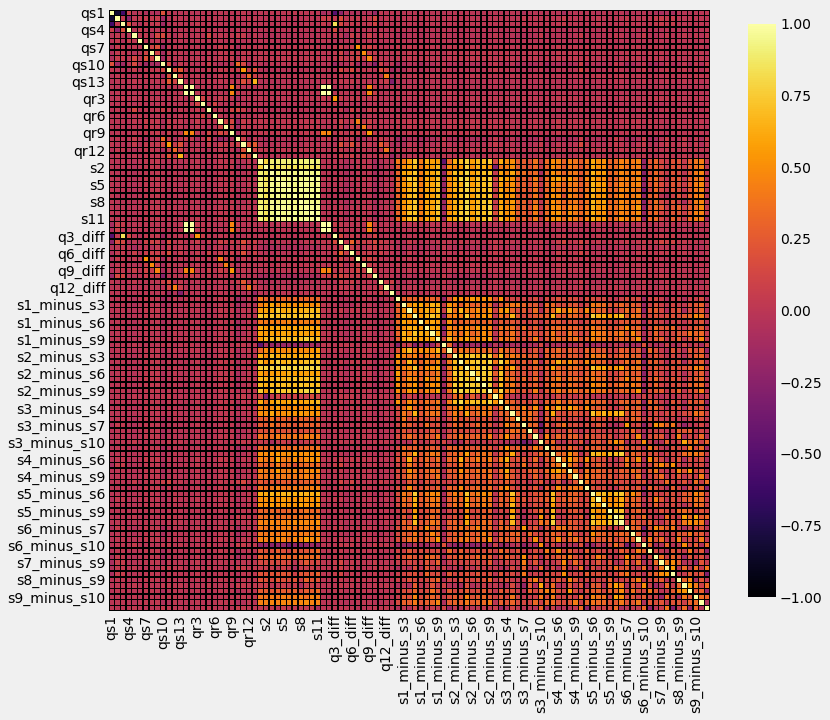

CPU times: user 3min 53s, sys: 4.5 s, total: 3min 58s
Wall time: 3min 58s


In [ ]:
%%time
corr = train_data_augmented.drop('target', axis=1).corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(corr,  vmin=-1, vmax=1, center=0, cmap='inferno',
                 linecolor='black', linewidths=0.5, square=True,
                 cbar_kws={"shrink": .82})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Let's see how each feature is correlated with the target variable:

In [ ]:
label_correlation = train_data_augmented.corr()

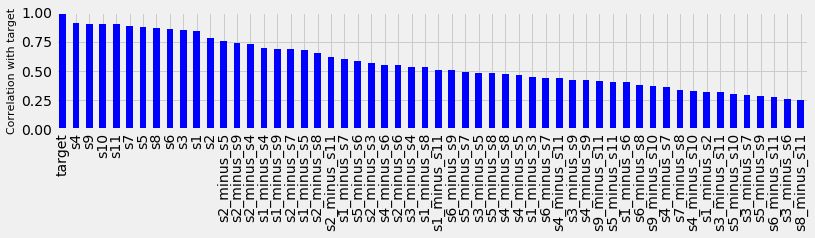

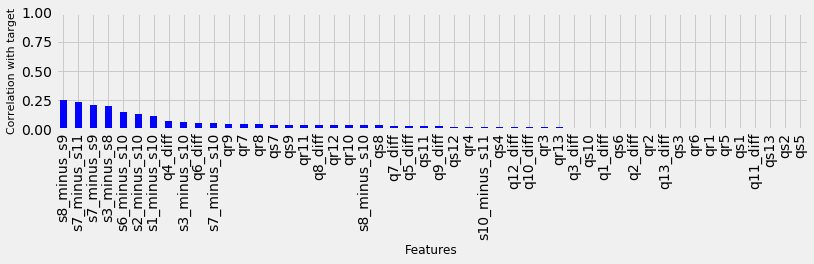

In [ ]:
plt.figure(figsize=(12,2))
label_correlation['target'].abs().sort_values(ascending=False)[:56] \
        .plot.bar(color='blue')
plt.ylabel('Correlation with target', fontsize=11)
plt.ylim(0.0, 1.0)
plt.show()

plt.figure(figsize=(12,2))
label_correlation['target'].abs().sort_values(ascending=False)[56:] \
        .plot.bar(color='blue')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation with target', fontsize=11)
plt.ylim(0.0, 1.0)
plt.show()

The output of face recognition algorithms are highly correlated with the target variable. Thus, they should be kept in the training set.

We will also keep image features which display low correlation with the target variable: individually they might not play a huge role in classification, but since we are using gradient tree boosting algorithms, they could be paired with the face recognition outputs, increasing predictive power.

## **2.4. Linear Class Separability with PCA**

Let's check now if our training dataset is linearly separable and if our redundant features can be reduced to fewer latent variables.

Running PCA on the entire 10 million observations blew Google Colab's RAM. Thus, I decided to only use 50% of the training set for PCA.

In [ ]:
y = train_labels['y'].values
n_samples = len(y) // 2
X_resampled, y_resampled = resample(train_data_augmented, y,
                                    n_samples=n_samples, replace=False,
                                    stratify=y, random_state=RANDOM_STATE)
print(X_resampled.shape, y_resampled.shape)
print(pd.Series(y_resampled).value_counts(True))

(4900356, 105) (4900356,)
0    0.931326
1    0.068674
dtype: float64


The following Quantile Transformation (a non-parametric version of Power Transformation Schemes such as Box-Cox or Yeo-Johnson) is used to reduce the influence of outliers and better capture the global picture:

In [ ]:
%%time
X_resampled_scaled = QuantileTransformer().fit_transform(X_resampled)
X_resampled_scaled = StandardScaler().fit_transform(X_resampled_scaled)

CPU times: user 2min 40s, sys: 155 ms, total: 2min 40s
Wall time: 2min 40s


In [ ]:
%%time
nb_features = X_resampled_scaled.shape[1]
pca = PCA(n_components=nb_features, random_state=RANDOM_STATE)
pca.fit(X_resampled_scaled);

CPU times: user 4min 27s, sys: 20 s, total: 4min 47s
Wall time: 1min 26s


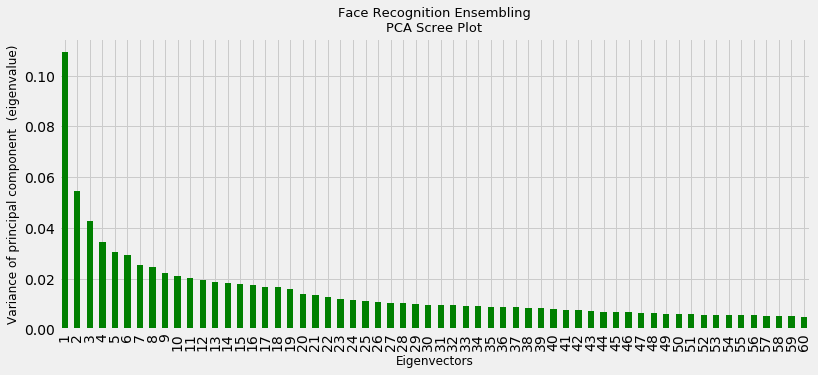

In [ ]:
plt.figure(figsize=(12,5))
pd.Series(pca.explained_variance_ratio_,
          index=np.arange(1, len(pca.explained_variance_ratio_)+1)).head(60) \
          .plot.bar(color='green')
plt.xlabel('Eigenvectors', fontsize=12)
plt.ylabel('Variance of principal component  (eigenvalue)', fontsize=12)
plt.title('Face Recognition Ensembling\nPCA Scree Plot', fontsize=13)
plt.show()

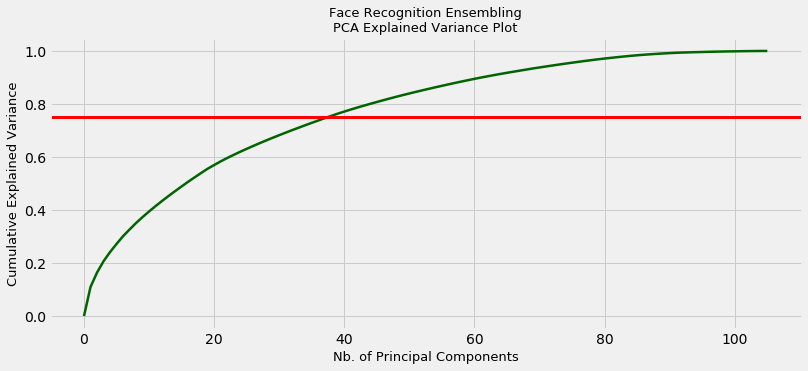

In [ ]:
plt.figure(figsize=(12,5))
explained_variance_plot = [0.0]+list(np.cumsum(pca.explained_variance_ratio_))
plt.plot(explained_variance_plot, color='darkgreen', lw=2.5)
plt.axhline(y=0.75, color='red', lw=3.0)
plt.xlabel('Nb. of Principal Components', fontsize=13)
plt.ylabel('Cumulative Explained Variance', fontsize=13)
plt.title('Face Recognition Ensembling\nPCA Explained Variance Plot', fontsize=13)
plt.show()

In [ ]:
X_train_pca = pca.transform(X_resampled_scaled)
evr1 = round(pca.explained_variance_ratio_[0], 2)
evr2 = round(pca.explained_variance_ratio_[1], 2)

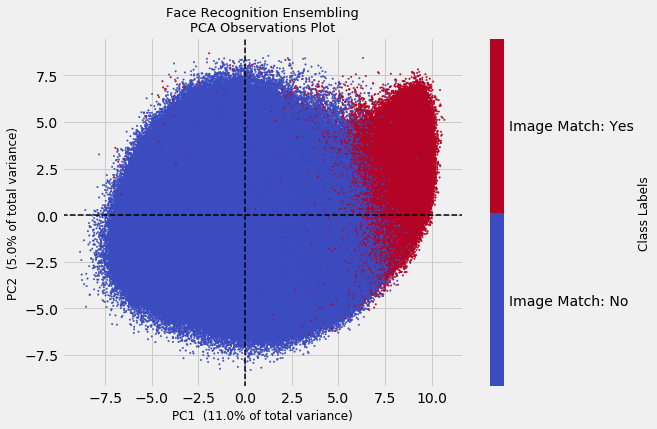

CPU times: user 1min 58s, sys: 657 ms, total: 1min 59s
Wall time: 1min 58s


In [ ]:
%%time
classes = list(set(y_resampled))
classes_names = ['Image Match: No', 'Image Match: Yes']

f, ax = plt.subplots(figsize=(8,6))

plt.scatter(X_train_pca[:,0], X_train_pca[:,1], s=2.0,
            c=y_resampled, cmap='coolwarm', alpha=1.0)
plt.axhline(0.0, color='black', ls='--', lw=1.5)
plt.axvline(0.0, color='black', ls='--', lw=1.5)

cbar = plt.colorbar(boundaries=np.arange(len(classes)+1)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(classes_names)
cbar.ax.set_ylabel('Class Labels', fontsize=12)

plt.title('Face Recognition Ensembling\nPCA Observations Plot', fontsize=13)
plt.xlabel("PC1  ({}% of total variance)".format(round(evr1*100,1)),
           fontsize=12)
plt.ylabel("PC2  ({}% of total variance)".format(round(evr2*100,1)),
           fontsize=12)
plt.show()

**Interpretation**:

- PCA's Observations Plot reveals that there is some **form of linear separability**, although this observation should be nuanced by the fact that the first 2 principal only explain about 16% of the input variance;
- About 40 principal components are required to give a good description of the original dataset (explaining 80% of data inertia);
- Some features - specifically the outputs of face recognition algorithms - are extremely correlated with the target variable, explaining why we can observe **linear separability with the first principal components PC1 and PC2**. But since they only account for **only 16% of total input variance**, they are not enough by themselves to describe the entirety of the dataset.

# **3. Model Training <a name="models"></a>**

**Models**

Initially, I focused exclusively on **state-of-the-art Gradient Boosting algorithms** optimized for large datasets and especially tabular datasets:

- XGBoost: released in 2016 by Tianqi Chen
- LightGBM: released in 2017 by Microsoft Research
- CatBoost: released in 2019 by Yandex

Fully-Connected Neural Networks proved to be too slow and not well-performing enough to warrant consideration. I tried LDA and Logistic Regression, but both either produced poor performance or blew Google Colab's RAM limit.

As the competition approached to an end, I decided to experiment with **stacking** and was successful in increasing my leaderboard score.

**Validation strategy**

The size of the dataset and the ensuing computational expense of computing many k-folds meant that a simple holdout validation split was sufficient enough. The extremely small size of the validation set (only 1% of the original training set) stems from a recommendation by Andrew Ng in his Deep Learning Coursera Specialization.

In [ ]:
X_train, X_valid, y_train, y_valid = \
                          train_test_split(train_data_augmented,
                                            train_labels['y'].values,
                                            test_size=0.01,
                                            stratify=train_labels['y'].values,
                                            random_state=RANDOM_STATE)

In [16]:
print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)

(9702705, 105) (98008, 105)
(9702705,) (98008,)


## **3.1. XGBoost <a name="xgb"></a>**

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/6/69/XGBoost_logo.png"  width="350" height="150"/>
</p>

<br>

**XGBoost** was developped in 2016 by Tianqi Chen as a custom variant of Gradient Tree Boosting that better suited his research requirements. After successfully winning the Higgs Machine Learning Competition (particule physics competition with 11 million observations), XGBoost grew in popularity and features heavily in the winning solutions of many Kaggle competitions. Compared to Vanilla Gradient Tree Boosting, XGBoost brings to the table numerous improvements, those relevant to this competition being:
- **Better Loss Approximation with 2nd Order Taylor Approximation**: Better accuracy and faster runtime
- **GPU Support**
- **Implicit Regularization**: Early Stopping on validation set (akin to Deep Learning)
- **Explicit Regularization**: Tree leaf penalization

For this competition, we are only **looking at Partial AUC** (or the ROC Curve's TPR if the FPR is set at $10^{-4}$). This requires simply creating a custom XGBoost evaluation metric and using it as our early stopping criterion: a ROC AUC Score set with `max_fpr=10**-4`.

In [ ]:
# Custom Metric
def partial_auc_xgboost(preds, dtrain):
    labels = dtrain.get_label()
    return 'P_AUC', roc_auc_score(labels, preds, max_fpr=10**-4)

# Scikit-Learn Wrapper
class XGBoostWrapper(object):
    def __init__(self, params=None):
        self.params = params

    def train(self, X_train, X_valid, y_train, y_valid,
              nb_iterations=3000, early_stopping_iter=500,
              verbose_eval=50):
        params = self.params
        xgboost_train = xgb.DMatrix(X_train, label=y_train, nthread=1)
        xgboost_valid = xgb.DMatrix(X_valid, label=y_valid, nthread=1)
        eval_list = [(xgboost_valid, 'valid')]

        clf = xgb.train(params=params,
                        dtrain=xgboost_train,
                        num_boost_round=nb_iterations,
                        early_stopping_rounds=early_stopping_iter,
                        evals=eval_list,
                        verbose_eval=verbose_eval,
                        feval=partial_auc_xgboost,
                        maximize=True)
        self.best_iter = clf.best_iteration
        self.clf = clf

    def predict(self, X):
        return self.clf.predict(xgb.DMatrix(X), ntree_limit=self.best_iter)

Hyperparameters of interest:

- **tree_method**: The algorithm used to build individual trees. As the training set is extremely large (10 million observations), I found that the best option was to use `gpu_hist` as it never lead to any RAM issue. This is a histogram-based algorithm where continuous values are discretized into bins, which speeds up the search for the optimal split (the same method used for LightGBM).
- **eta**: shrinkage rate. Value of 0.1 is a good comprise between speed and convergence.
- **max_depth**: maximum tree depth. Higher values lead to more complex trees. The value of 12 is arbitrary and comes more from standard practice of using values between 8 and 12.
- **alpha**: $L_1$-regularization on trees. Value of 3 is actually quite high, but is due to the large gap between performances on the validation set and those on the testing set.
- **lambda**: $L_2$-regularization on trees. Same logic as $L_1$-regularization, with the added benefit of reducing the effect of data multicollinearity.
- **scale_pos_weight**: parameter for handling class imbalance, typically the value chosen is the ratio between the sum of examples from the majority class and those from the minority class, here close to 7.

In [ ]:
xgb_hyperparameters = {'booster': 'gbtree',
                       'tree_method': 'gpu_hist',
                       'eta': 0.1,
                       'colsample_bytree': 1.0,
                       'subsample': 1.0,
                       'objective': 'binary:logistic',
                       'max_depth': 12,
                       'alpha': 3.0,
                       'lambda': 3.0,
                       'num_parallel_tree': 1,
                       'scale_pos_weight': 7,
                       'seed': RANDOM_STATE
                       }

We train our model with **early stopping** using a hold-out validation set:

In [ ]:
%%time
xgboostClassifier = XGBoostWrapper(xgb_hyperparameters)
xgboostClassifier.train(X_train, X_valid, y_train, y_valid)
y_prob_valid_xgb = xgboostClassifier.predict(X_valid)

[0]	valid-error:0.00303	valid-P_AUC:0.864421
Multiple eval metrics have been passed: 'valid-P_AUC' will be used for early stopping.

Will train until valid-P_AUC hasn't improved in 500 rounds.
[50]	valid-error:0.002051	valid-P_AUC:0.966903
[100]	valid-error:0.001775	valid-P_AUC:0.975519
[150]	valid-error:0.001459	valid-P_AUC:0.978945
[200]	valid-error:0.001388	valid-P_AUC:0.980462
[250]	valid-error:0.001255	valid-P_AUC:0.98189
[300]	valid-error:0.001255	valid-P_AUC:0.982409
[350]	valid-error:0.001194	valid-P_AUC:0.98305
[400]	valid-error:0.001143	valid-P_AUC:0.983733
[450]	valid-error:0.001122	valid-P_AUC:0.984258
[500]	valid-error:0.001082	valid-P_AUC:0.984709
[550]	valid-error:0.001061	valid-P_AUC:0.98485
[600]	valid-error:0.001031	valid-P_AUC:0.985289
[650]	valid-error:0.00098	valid-P_AUC:0.9856
[700]	valid-error:0.000939	valid-P_AUC:0.985756
[750]	valid-error:0.000939	valid-P_AUC:0.986023
[800]	valid-error:0.000877	valid-P_AUC:0.986451
[850]	valid-error:0.000847	valid-P_AUC:0.98648

Performances on validation set:

In [ ]:
print('AUC (Valid):', roc_auc_score(y_valid, y_prob_valid_xgb, max_fpr=10**-4))
print('AP  (Valid):', average_precision_score(y_valid, y_prob_valid_xgb))

AUC (Valid): 0.9879248475152831
AP  (Valid): 0.9998210908240422


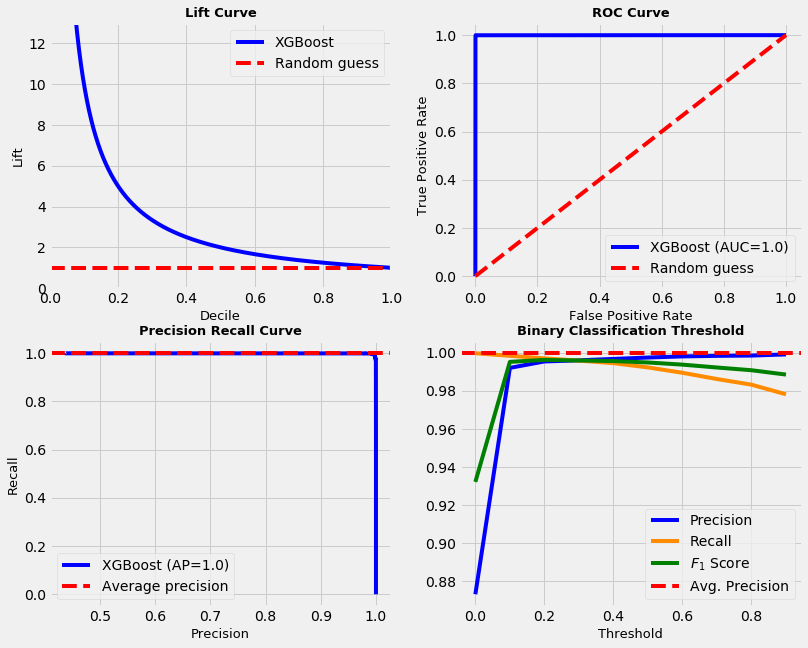

CPU times: user 2.18 s, sys: 602 ms, total: 2.78 s
Wall time: 2.1 s


In [ ]:
%%time
f, ax = plt.subplots(2, 2, figsize=(12,10))
plot_lift_curve(y_valid, y_prob_valid_xgb, model_name='XGBoost', ax=ax[0,0])
plot_roc_curve(y_valid, y_prob_valid_xgb, model_name='XGBoost', ax=ax[0,1])
plot_precision_recall_curve(y_valid, y_prob_valid_xgb, model_name='XGBoost',
                            ax=ax[1,0])
plot_discrimination_threshold(y_valid, y_prob_valid_xgb, ax=ax[1,1])
plt.show()

We persist our model for future re-use:

In [ ]:
joblib.dump(xgboostClassifier, 'MODELS/MDI343_XGBOOST.pkl');
xgboostClassifier = joblib.load('MODELS/MDI343_XGBOOST.pkl')

## **3.2. LightGBM <a name="lgb"></a>**

<br>

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/Microsoft_Research_Asia_logo.png/640px-Microsoft_Research_Asia_logo.png"  width="450" height="200"/>
</p>

<br>

LightGBM was developped by Microsoft Research and released in 2017. Its aim is simply to be faster than XGBoost. They achieved this by:
- **Discretizing into bins each continuous feature at split time**. Instead of greedily sweeping every data point, LightGBM only sweeps over bins (called histogram-based). This speeds up training considerably;
- **Most promising leaves are prioritized during tree growth**. XGBoost's default implementation grows trees equally across branches creating equal but wide trees. LightGBM prefers to only grows promising leaves, creating asymetric trees. In the process, this saves memory usage during training (that being said XGBoost also implements this optimization with the `gpu_hist` option).

Similar to XGBoost, I will use a custom metric (ROC AUC Score at at `max_fpr=10**-4`) for early stopping.


In [ ]:
# Custom Metric
def partial_auc_lightgbm(preds, train_data):
    labels = train_data.get_label()
    return 'P_AUC', roc_auc_score(labels, preds, max_fpr=10**-4), True

custom_metric = lambda preds, train_data: \
                [partial_auc_lightgbm(preds, train_data)]

# Scikit-Learn Wrapper
class LightGBMWrapper(object):
    def __init__(self, params=None):
        self.params = params

    def train(self, X_train, X_valid, y_train, y_valid,
              nb_iterations=3000, early_stopping_iter=500,
              verbose_eval=50):
        params = self.params
        lgb_train = lgb.Dataset(X_train, label=y_train)
        lgb_valid = lgb.Dataset(X_valid, label=y_valid)

        clf = lgb.train(params=params,
                        train_set=lgb_train,
                        num_boost_round=nb_iterations,
                        valid_sets=lgb_valid,
                        feval=custom_metric,
                        verbose_eval=verbose_eval,
                        early_stopping_rounds=early_stopping_iter)
        self.clf = clf

    def predict(self, X):
        return self.clf.predict(X)

Hyperparameters of interest:

- **boosting_type**: there are 4 boosting types offered by LightGBM, which are `gbdt` (default option), `goss` (slightly faster), `dart` (drops trees for prediction but extremely slow) and `rf` (random forests). In practice, `gbdt` and `goss` behave similarly;
- **num_leaves**: this parameter was set arbitrarily whereas convention is to set it at $2^d$ where $d$ is depth. A significantly lower value does reduce risk of overfitting.

In [ ]:
lgb_hyperparameters = {'objective': 'binary',
                       'boosting_type': 'goss',
                       'device_type': 'gpu',
                       'metric': 'custom',
                       'reg_lambda': 3.0,
                       'reg_alpha': 3.0,
                       'class_weight': 'is_unbalance',
                       'max_depth': 12,
                       'num_leaves': 150,
                       'feature_fraction': 0.95,
                       'learning_rate': 0.1,
                       'random_state': RANDOM_STATE
                       }

We train our model with early stopping using a hold-out validation set:

In [ ]:
%%time
lightGbmClassifier = LightGBMWrapper(lgb_hyperparameters)
lightGbmClassifier.train(X_train, X_valid, y_train, y_valid,
                         verbose_eval=50)
y_prob_valid_lgb = lightGbmClassifier.predict(X_valid)

Training until validation scores don't improve for 500 rounds
[50]	valid_0's P_AUC: 0.950616
[100]	valid_0's P_AUC: 0.971087
[150]	valid_0's P_AUC: 0.975944
[200]	valid_0's P_AUC: 0.979359
[250]	valid_0's P_AUC: 0.981107
[300]	valid_0's P_AUC: 0.982477
[350]	valid_0's P_AUC: 0.983634
[400]	valid_0's P_AUC: 0.984581
[450]	valid_0's P_AUC: 0.984886
[500]	valid_0's P_AUC: 0.985368
[550]	valid_0's P_AUC: 0.985877
[600]	valid_0's P_AUC: 0.985985
[650]	valid_0's P_AUC: 0.986276
[700]	valid_0's P_AUC: 0.986696
[750]	valid_0's P_AUC: 0.987126
[800]	valid_0's P_AUC: 0.987318
[850]	valid_0's P_AUC: 0.98759
[900]	valid_0's P_AUC: 0.987898
[950]	valid_0's P_AUC: 0.988085
[1000]	valid_0's P_AUC: 0.988279
[1050]	valid_0's P_AUC: 0.98839
[1100]	valid_0's P_AUC: 0.988578
[1150]	valid_0's P_AUC: 0.988617
[1200]	valid_0's P_AUC: 0.988785
[1250]	valid_0's P_AUC: 0.988842
[1300]	valid_0's P_AUC: 0.988948
[1350]	valid_0's P_AUC: 0.988993
[1400]	valid_0's P_AUC: 0.989104
[1450]	valid_0's P_AUC: 0.989144
[15

Performances on validation set:

In [ ]:
%%time
print('AUC (Valid):', roc_auc_score(y_valid, y_prob_valid_lgb, max_fpr=10**-4))
print('AP  (Valid):', average_precision_score(y_valid, y_prob_valid_lgb))

AUC (Valid): 0.9891444408827665
AP  (Valid): 0.9998463545034906
CPU times: user 60.3 ms, sys: 3 ms, total: 63.3 ms
Wall time: 61.7 ms


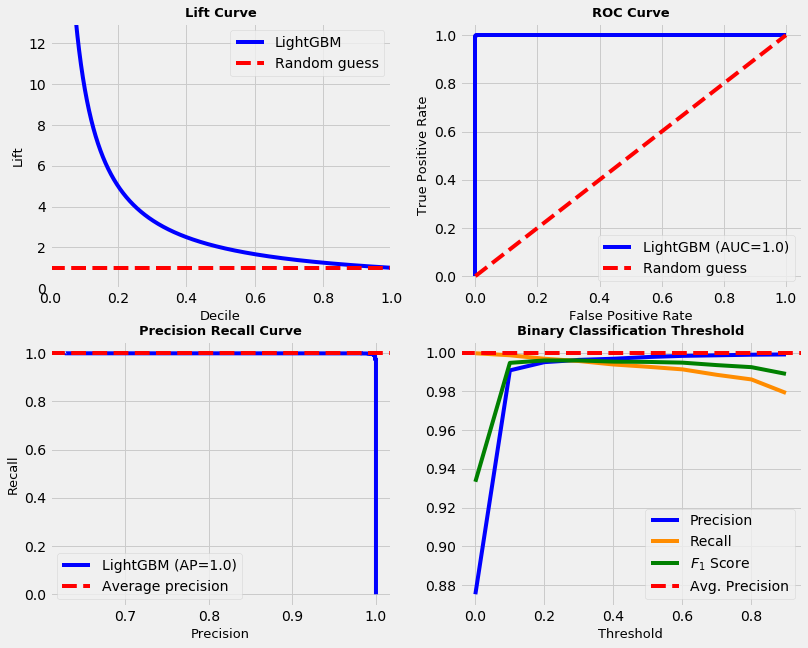

CPU times: user 1.96 s, sys: 635 ms, total: 2.6 s
Wall time: 1.89 s


In [ ]:
%%time
f, ax = plt.subplots(2, 2, figsize=(12,10))
plot_lift_curve(y_valid, y_prob_valid_lgb, model_name='LightGBM', ax=ax[0,0])
plot_roc_curve(y_valid, y_prob_valid_lgb, model_name='LightGBM', ax=ax[0,1])
plot_precision_recall_curve(y_valid, y_prob_valid_lgb, model_name='LightGBM',
                            ax=ax[1,0])
plot_discrimination_threshold(y_valid, y_prob_valid_lgb, ax=ax[1,1])
plt.show()

We persist our model for future re-use:

In [ ]:
joblib.dump(lightGbmClassifier, 'MODELS/MDI343_LIGHTGBM.pkl');
lightGbmClassifier = joblib.load('MODELS/MDI343_LIGHTGBM.pkl')

## **3.3. CatBoost <a name="cbt"></a>**

<br>

<p align="center">
  <img src="https://miro.medium.com/max/1200/0*PVsk4fHxyT6vocqN"  width="550" height="300"/>
</p>

<br>

CatBoost was developped by Yandex and was also released in 2017. Contrasting LightGBM's goal of simply besting XGBoost at speed, CatBoost's goal is better generalization than its previous competitors.

CatBoost's claim to fame is its easier handling of categorical features. But as the training set doesn't contain categorical features, this advantage will not be used. It supposedly provides **better generalization on smaller datasets** by reducing tree correlation by randomly shuffling observations at splitting time.

Unfortunately, **CatBoost's GPU implementation doesn't support custom metrics for early stopping** (even something as simple as a custom Scikit-Learn ROC AUC). Thus I will have to use regular AUC. This means CatBoost will necessarily produce less accurate predictions than XGBoost and LightGBM.


In [ ]:
# Custom Metric (doesn't work with GPU)
# class partial_auc_catboost(object):
#     def get_final_error(self, error, weight):
#         return error / (weight + 1e-38)
    
#     def is_max_optimal(self):
#         return True

#     def evaluate(self, approxes, target, weight):
#         # approxes is list of indexed containers (containers with only
#         # __len__ and __getitem__ defined), one container per approx
#         # dimension. Each container contains floats. weight is one
#         # dimensional indexed container. Target is float.

#         # weight parameter can be None.
#         # Returns pair (error, weights sum)

#         assert len(approxes) == 1
#         assert len(target) == len(approxes[0])

#         approx = approxes[0]

#         error_sum = 0.0
#         weight_sum = 1.0

#         # error_sum = gini_normalized(target, approx)
#         error_sum = roc_auc_score(target, approx, max_fpr=10**-4)

#         return error_sum, weight_sum

# Scikit-Learn Wrapper
class CatBoostWrapper(object):
    def __init__(self, params=None):
        self.params = params

    def train(self, X_train, X_valid, y_train, y_valid,
              nb_iterations=3000, early_stopping_iter=500,
              verbose_eval=50):
        params = self.params
        valid_pool = cbt.Pool(data=X_valid, label=y_valid)

        clf = cbt.CatBoostClassifier(**params)
        clf.fit(X_train, y_train, use_best_model=True,
                eval_set=valid_pool, verbose_eval=verbose_eval,
                early_stopping_rounds=early_stopping_iter)
        self.clf = clf

    def predict(self, X):
        return self.clf.predict_proba(X)[:,1]

Compared to XGBoost and LightGBM, I am less familar with CatBoost's hyperparameters, thus my hyperparameter choices mirrored those of XGBoost and LightGBM (minus $L_1$-regularization as it is not available).

In [ ]:
cbt_hyperparameters = {'iterations': 5000,
                       'learning_rate': 0.1,
                       'depth': 12,
                       'l2_leaf_reg': 5,
                       'bootstrap_type': 'Bernoulli',
                       'subsample': 0.95,
                       'scale_pos_weight': 7,
                       'eval_metric': 'AUC',
                       'od_type': 'Iter',
                       'allow_writing_files': False,
                       'task_type': 'GPU',
                       'od_wait': 500,
                       'random_seed': RANDOM_STATE
                       }

We train our model with early stopping using a hold-out validation set:

In [ ]:
%%time
catBoostClassifier = CatBoostWrapper(cbt_hyperparameters)
catBoostClassifier.train(X_train, X_valid, y_train, y_valid,
                         verbose_eval=200)
y_prob_valid_cbt = catBoostClassifier.predict(X_valid)

0:	learn: 0.9984995	test: 0.9983306	best: 0.9983306 (0)	total: 269ms	remaining: 22m 26s
200:	learn: 0.9999694	test: 0.9999200	best: 0.9999200 (200)	total: 51.9s	remaining: 20m 39s
400:	learn: 0.9999946	test: 0.9999579	best: 0.9999579 (399)	total: 1m 43s	remaining: 19m 47s
600:	learn: 0.9999982	test: 0.9999706	best: 0.9999707 (591)	total: 2m 34s	remaining: 18m 53s
800:	learn: 0.9999995	test: 0.9999774	best: 0.9999774 (799)	total: 3m 25s	remaining: 17m 58s
1000:	learn: 0.9999998	test: 0.9999807	best: 0.9999808 (994)	total: 4m 16s	remaining: 17m 2s
1200:	learn: 0.9999999	test: 0.9999826	best: 0.9999826 (1195)	total: 5m 5s	remaining: 16m 5s
1400:	learn: 0.9999999	test: 0.9999845	best: 0.9999845 (1397)	total: 5m 54s	remaining: 15m 11s
1600:	learn: 1.0000000	test: 0.9999854	best: 0.9999854 (1600)	total: 6m 44s	remaining: 14m 18s
1800:	learn: 1.0000000	test: 0.9999861	best: 0.9999861 (1766)	total: 7m 34s	remaining: 13m 26s
2000:	learn: 1.0000000	test: 0.9999865	best: 0.9999866 (1994)	total: 8

Performances on validation set:

In [ ]:
print('AUC (Valid):', roc_auc_score(y_valid, y_prob_valid_cbt, max_fpr=10**-4))
print('AP  (Valid):', average_precision_score(y_valid, y_prob_valid_cbt))

AUC (Valid): 0.9844934677804044
AP  (Valid): 0.9998587008801836


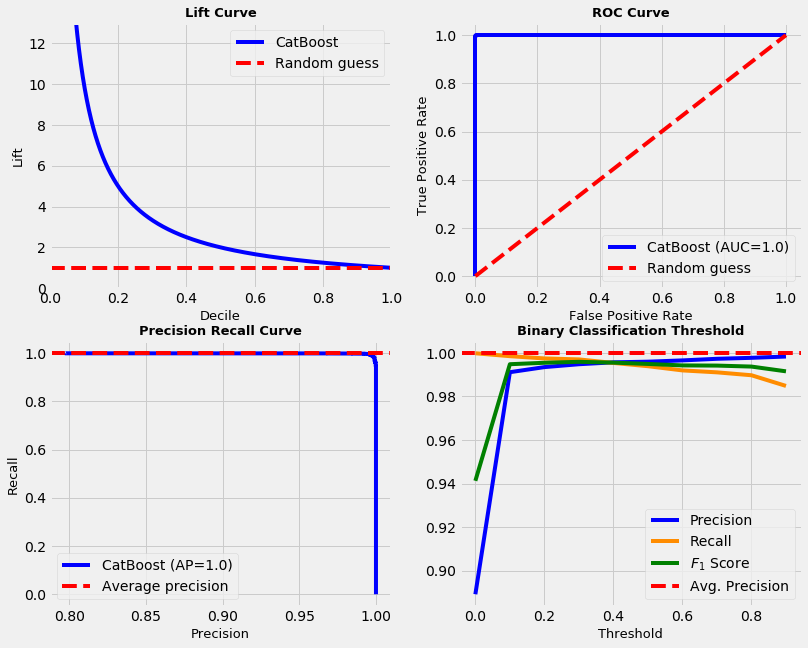

CPU times: user 2.19 s, sys: 620 ms, total: 2.81 s
Wall time: 2.11 s


In [ ]:
%%time
f, ax = plt.subplots(2, 2, figsize=(12,10))
plot_lift_curve(y_valid, y_prob_valid_cbt, model_name='CatBoost', ax=ax[0,0])
plot_roc_curve(y_valid, y_prob_valid_cbt, model_name='CatBoost', ax=ax[0,1])
plot_precision_recall_curve(y_valid, y_prob_valid_cbt, model_name='CatBoost',
                            ax=ax[1,0])
plot_discrimination_threshold(y_valid, y_prob_valid_cbt, ax=ax[1,1])
plt.show()

We persist our model for future re-use:

In [ ]:
joblib.dump(catBoostClassifier, 'MODELS/MDI343_CATBOOST.pkl');
catBoostClassifier = joblib.load('MODELS/MDI343_CATBOOST.pkl')

## **3.4. Stacking <a name="stacked"></a>**

First developped in the 1990s, notably by Wolpert (1992), stacking consists in:
- Making several predictions from different models on a holdout validation set;
- Then the **predictions are used as *meta-features* fed into a meta model** (typically a linear model such as Logistic Regression in classification). From the meta model, we output our final prediction which acts as a **blend of different models**.

<br>

<p align="center">
  <img src="https://burakhimmetoglu.files.wordpress.com/2016/12/workflow.png?w=1140"  width="580" height="250"/>
</p>

<br>

The most naive form of stacking is simply (weighted) averaging of predictions. This version with meta-model is more sophisticated, as some predictions from stronger models might be more useful than others but the latter (from simpler but more robust models) might be worth keeping for better generalization.

Here the only models we will use for stacking are from Extreme Gradient Boosting algorithms (e.g. XGBoost, LightGBM, CatBoost). Since we already splitted our initial dataset into a training and validation set and we already have the predictions for our 3 models, we **form a new dataset for validation via stacking the predictions**:

In [ ]:
xgboostClassifier = joblib.load('MODELS/MDI343_XGBOOST.pkl')
lightGbmClassifier = joblib.load('MODELS/MDI343_LIGHTGBM.pkl')
catBoostClassifier = joblib.load('MODELS/MDI343_CATBOOST.pkl')

In [ ]:
y_prob_valid_xgb = xgboostClassifier.predict(X_valid)
y_prob_valid_lgb = lightGbmClassifier.predict(X_valid)
y_prob_valid_cbt = catBoostClassifier.predict(X_valid)

In [22]:
# XGBoost + LightGBM + CatBoost
validation_preds = (y_prob_valid_xgb, y_prob_valid_lgb, y_prob_valid_cbt)
stacked_predictions = np.column_stack(validation_preds)
print(stacked_predictions.shape)

(98008, 3)


We specify a meta learner and we fit this model made on the stacked predictions:

In [ ]:
# Turn off regularization with C=1e10
meta_model = LogisticRegression(C=1e10)
meta_model.fit(stacked_predictions, y_valid)
y_prob_valid_stacked = meta_model.predict_proba(stacked_predictions)[:,1]

We can look at the Logistic Regression coefficients:

In [33]:
pd.Series(meta_model.coef_[0], index=['XGBoost', 'LightGBM', 'CatBoost'])

XGBoost     5.106967
LightGBM    6.718114
CatBoost    5.225759
dtype: float64

Performances on validation set:

In [34]:
print('AUC (Valid):', roc_auc_score(y_valid, y_prob_valid_stacked, max_fpr=10**-4))
print('AP  (Valid):', average_precision_score(y_valid, y_prob_valid_stacked))

AUC (Valid): 0.9884318721472449
AP  (Valid): 0.9998649649843478


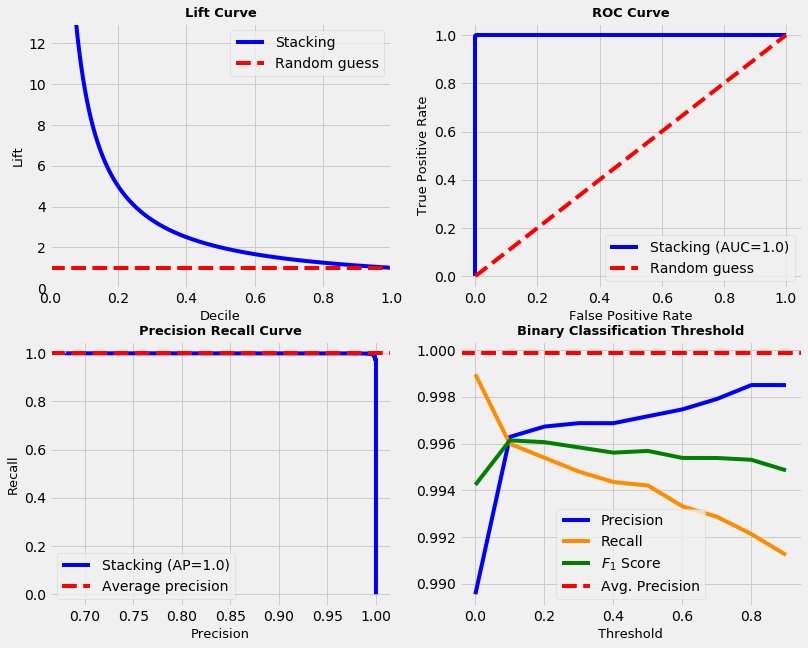

CPU times: user 2.28 s, sys: 648 ms, total: 2.93 s
Wall time: 2.3 s


In [35]:
%%time
f, ax = plt.subplots(2, 2, figsize=(12,10))
plot_lift_curve(y_valid, y_prob_valid_stacked, model_name='Stacking',
                ax=ax[0,0])
plot_roc_curve(y_valid, y_prob_valid_stacked, model_name='Stacking',
               ax=ax[0,1])
plot_precision_recall_curve(y_valid, y_prob_valid_stacked, model_name='Stacking',
                            ax=ax[1,0])
plot_discrimination_threshold(y_valid, y_prob_valid_stacked, ax=ax[1,1])
plt.show()

We save our stacked meta learner:

In [ ]:
joblib.dump(meta_model, 'MODELS/MDI343_STACKED_MODEL.pkl');
meta_model = joblib.load('MODELS/MDI343_STACKED_MODEL.pkl')

# **4. Testing Set Predictions <a name="test"></a>**

Reutilize previously trained models:

In [ ]:
xgboostClassifier = joblib.load('MODELS/MDI343_XGBOOST.pkl')
lightGbmClassifier = joblib.load('MODELS/MDI343_LIGHTGBM.pkl')
catBoostClassifier = joblib.load('MODELS/MDI343_CATBOOST.pkl')
meta_model = joblib.load('MODELS/MDI343_STACKED_MODEL.pkl')

In [ ]:
# Extreme Gradient Boosting
y_prob_valid_xgb = xgboostClassifier.predict(X_valid)
y_prob_valid_lgb = lightGbmClassifier.predict(X_valid)
y_prob_valid_cbt = catBoostClassifier.predict(X_valid)

# Stacking
validation_preds = (y_prob_valid_xgb, y_prob_valid_lgb, y_prob_valid_cbt)
stacked_predictions = np.column_stack(validation_preds)
y_prob_valid_stacked = meta_model.predict_proba(stacked_predictions)[:,1]

In [39]:
print('XGBoost AUC (Valid):\t', roc_auc_score(y_valid, y_prob_valid_xgb, max_fpr=10**-4))
print('LightGBM AUC (Valid):\t', roc_auc_score(y_valid, y_prob_valid_lgb, max_fpr=10**-4))
print('CatBoost AUC (Valid):\t', roc_auc_score(y_valid, y_prob_valid_cbt, max_fpr=10**-4))
print('Stacked AUC (Valid):\t', roc_auc_score(y_valid, y_prob_valid_stacked, max_fpr=10**-4))

XGBoost AUC (Valid):	 0.9879248475152831
LightGBM AUC (Valid):	 0.9891444408827665
CatBoost AUC (Valid):	 0.9844934677804044
Stacked AUC (Valid):	 0.9884318721472449


In [ ]:
def best_tpr_at_max_fpr(y_true, y_pred, max_fpr):
    fprs, tprs, _ = roc_curve(y_true, y_pred)
    for i, fpr in enumerate(fprs):
        if fpr > max_fpr:
            best_tpr = tprs[i-1]
            break
    return best_tpr

In [41]:
print('XGBoost TPR (Valid):\t', best_tpr_at_max_fpr(y_valid, y_prob_valid_xgb, max_fpr=10**-4))
print('LightGBM TPR (Valid):\t', best_tpr_at_max_fpr(y_valid, y_prob_valid_lgb, max_fpr=10**-4))
print('CatBoost TPR (Valid):\t', best_tpr_at_max_fpr(y_valid, y_prob_valid_cbt, max_fpr=10**-4))
print('Stacked TPR (Valid):\t', best_tpr_at_max_fpr(y_valid, y_prob_valid_stacked, max_fpr=10**-4))

XGBoost TPR (Valid):	 0.9829148714901204
LightGBM TPR (Valid):	 0.988560392215124
CatBoost TPR (Valid):	 0.9833605704947259
Stacked TPR (Valid):	 0.9855890655177537


## **4.1. Best Model**

**Prepare Test Set**

In [ ]:
X_test = handcraftFeatureTransformer.transform(test_data_reduced)

In [43]:
print(X_test.shape)

(3768311, 105)


**Model 1: LightGBM GPU**

In [44]:
%%time
y_prob_test_lgb = lightGbmClassifier.predict(X_test)

CPU times: user 21min 34s, sys: 291 ms, total: 21min 34s
Wall time: 5min 30s


**Model 2: XGBoost GPU with histogram-based implementation**

In [45]:
%%time
y_prob_test_xgb = xgboostClassifier.predict(X_test)

CPU times: user 4min 21s, sys: 2min 59s, total: 7min 20s
Wall time: 7min 20s


**Model 3: CatBoost GPU**

In [46]:
%%time
y_prob_test_cbt = catBoostClassifier.predict(X_test)

CPU times: user 2min 49s, sys: 984 ms, total: 2min 50s
Wall time: 1min 24s


**Model 4: Stacked Model Blend with Logistic Regression**

In [47]:
%%time
# XGBoost + LightGBM + CatBoost
test_predictions = (y_prob_test_xgb, y_prob_test_lgb, y_prob_test_cbt)
stacked_test_predictions = np.column_stack(test_predictions)
y_prob_test_stacked = meta_model.predict_proba(stacked_test_predictions)[:,1]

CPU times: user 308 ms, sys: 308 ms, total: 617 ms
Wall time: 270 ms


**Submissions**

In [48]:
%%time
np.savetxt('SUBMISSIONS/model_024_lightgbm_gpu.csv', y_prob_test_lgb,
           fmt='%1.15f', delimiter=',')
np.savetxt('SUBMISSIONS/model_025_catboost_gpu.csv', y_prob_test_cbt,
           fmt='%1.15f', delimiter=',')
np.savetxt('SUBMISSIONS/model_026_xgboost_gpu.csv', y_prob_test_xgb,
           fmt='%1.15f', delimiter=',')
np.savetxt('SUBMISSIONS/model_027_stacking.csv', y_prob_test_stacked,
           fmt='%1.15f', delimiter=',')

CPU times: user 25.5 s, sys: 286 ms, total: 25.7 s
Wall time: 32.2 s


## **4.2. Testing Set Performance History**

Metric used is the ROC Curve's **True Positive Ratio (TPR) if the maximum tolerated False Positive Ratio (FPR) is set at $10^{-4}$**. This means we only tolerate 1 mistake every 1000 face recognition matches. We want extreme precision: mistakes are extremely rare anomalies.

**Key to increasing my leaderboard score was to ensure that (approximate) monotonic increases in my internal validation score also led to (approximate) monotonic increases in my leaderboard**.

Strategies explored:

| Model(s) | Feature Engineering | Stacking | Valid TPR | Test TPR |
|-------------| -------------|-------------|-------------:|-------------:|
| L-BFGS Logistic Regression (Baseline) | Initial Features | No | --- | 67.73% |
| LightGBM (First model) | Initial Features | No | --- | 87.75% |
| LightGBM | Initial Features + Interaction Features | No | 98.86% | 88.28% |
| CatBoost | Initial Features + Interaction Features | No | 98.34% | 87.98% |
| XGBoost | Initial Features + Interaction Features | No | 98.29% | 88.31% |
| **LightGBM + XGBoost + CatBoost** | **Initial Features + Interaction Features** | **Yes** | **98.56%** | **88.41%** |

<br>

# **5. Bonus: Machine Learning Interpretability with SHAP <a name="shap"></a>**

<br>

<p align="center">
  <img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.png"  width="480" height="280"/>
</p>

<br>

As a bonus, I will use Shapley coefficients (implemented with the SHAP library) from Cooperative Game Theory (Shapley, 1952) to decode the Extreme Gradient Boosting algorithms and the stacked learner. We will be able to identify the features that played a role in determining whether 2 images match.

Gradient boosting algorithms are not as black-box as Deep Learning algorithms since it is possible to display feature importance plots that highlight which features were frequently used during the training phase. Shapley coefficients are better however as they actually go so far as to **explain every prediction and specifically identify which features played a role in each individual prediction**.

## **5.1. LightGBM with SHAP Tree Explainer**

We will only look at LightGBM since XGBoost or CatBoost (having similar Partial AUC Scores) should behave similarily and computationally computing SHAP values is expensive.

In [ ]:
# Note: This takes 1h to run
tree_explainer = shap.TreeExplainer(model=lightGbmClassifier.clf, data=None,
                                    model_output='margin',
                                    feature_perturbation='tree_path_dependent')
tree_shap_values = tree_explainer.shap_values(X_valid)

In [ ]:
joblib.dump(tree_shap_values, 'MODELS/MDI343_SHAP_LIGHTGBM.pkl');

In [ ]:
tree_shap_values = joblib.load('MODELS/MDI343_SHAP_LIGHTGBM.pkl')

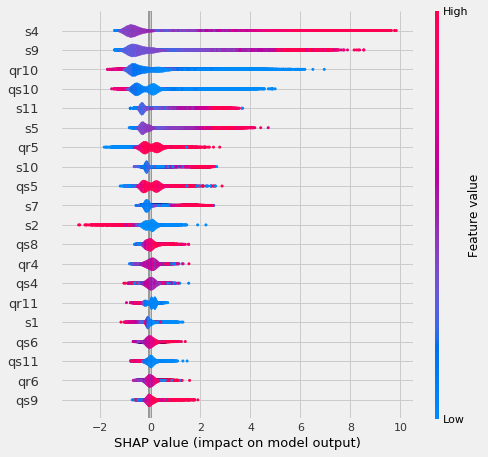

CPU times: user 35.2 s, sys: 8.18 s, total: 43.4 s
Wall time: 34.1 s


In [ ]:
%%time
shap.summary_plot(tree_shap_values[1], features=X_valid,
                  feature_names=X_valid.columns, plot_type='violin',
                  max_display=20, plot_size=(7,7))

**Interpretation**: SHAP's Summary Plot shows rather surprising results. 
- Unsuprisingly, the outputs of face recognition algorithms play a major role in determining whether 2 images match (as confirmed by the Pearson target correlation plots in Section 2.3.);
- Despite being lowly correlated with the target variable, the image features are actually major players in determining whether 2 images match, especially `qr10` / `qs10` and `qr5` / `qs5`;
- The created feature interactions don't seem to play an important in the decision-making process of LightGBM.

## **5.2. Stacked Learner with SHAP Linear Explainer**

Finally, this is just to show that linear models can be used with SHAP, as the decision-making process behind every predicted probability can be smoothly plotted (aka SHAP's Summary Plot).

In [ ]:
# Note: Take a few seconds to run
meta_model_explainer = shap.LinearExplainer(model=meta_model,
                                            data=stacked_predictions)
meta_model_shap_values = meta_model_explainer.shap_values(stacked_predictions)

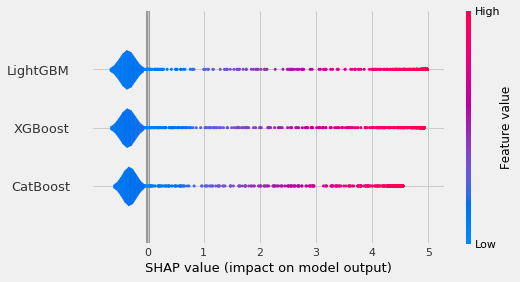

CPU times: user 5.3 s, sys: 1.28 s, total: 6.58 s
Wall time: 5.12 s


In [ ]:
%%time
shap.summary_plot(meta_model_shap_values, features=stacked_predictions,
                  feature_names=['XGBoost', 'LightGBM', 'CatBoost'],
                  plot_size=(7,4), plot_type='violin', max_display=5)

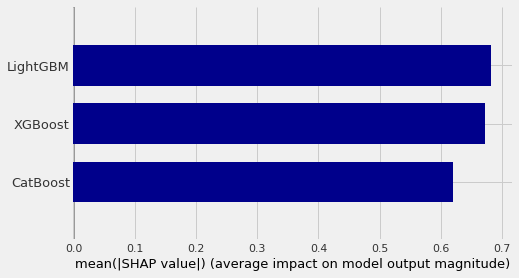

In [ ]:
shap.summary_plot(meta_model_shap_values, features=stacked_predictions,
                  feature_names=['XGBoost', 'LightGBM', 'CatBoost'],
                  plot_size=(7,4), plot_type='bar', color='darkblue',
                  max_display=5)

Of the 3 models used in the stacked learner, LightGBM provided the biggest contribution to the predicted probabilities generated by the stacked blend.

# **6. Conclusion <a name="conclusion"></a>**

For huge datasets, extreme gradient boosting algorithms (with the right idea of hyperparameters) are **extremely potent** especially when paired with GPUs.

Google Colab is a free service, thus inevitably there are limitations to the framework. If a user uses the GPU Execution Runtime Mode for too long, then he will lose temporarily GPU access. This is Google's policy to prioritize learners who don't use GPUs for too long (which is completely understandable). An ambitious (but costly and not necessarily productive) endeavour would have been to switch to **Google Colab Pro** (unfortunately not available in Europe) or setup a GCP Account and especially a Deep Learning VM. 

There is an interesting package I heard about at a PyData Paris conference called **VAEX** (essentially Pandas DataFrame for ginormous datasets), which is available on GitHub. This should merit further investigations, notably the following machine learning utilities:

```python
import vaex.ml.sklearn

vaex_xgb_classifier = \
  vaex.ml.sklearn.Predictor(features=X_train,
                            target='target',
                            model=xgb_classifier,
                            prediction_name='pred_proba_xgb')
```

This would have allowed me to add linear models to the stacking blend and increase diversification.

# **7. References**

**Feature Engineering**
- [Features Interactions | How to Win a Data Science Competition MOOC](https://www.youtube.com/watch?v=zjl4gdra7D0)

**XGBoost, LightGBM, CatBoost**

- [XGBoost (GitHub)](https://github.com/dmlc/xgboost)
- [LightGBM (GitHub)](https://github.com/microsoft/LightGBM)
- [CatBoost (GitHub)](https://github.com/catboost/catboost)
- [A decent article summarizing the differences between the 3 algorithms](https://lavanya.ai/2019/06/27/battle-of-the-boosting-algorithms/)
- [A complementary PyData video about XGBoost's competitors](https://www.youtube.com/watch?v=5CWwwtEM2TA)
- [Setting up LightGBM GPU on Google Colab](https://medium.com/mlreview/mastering-fast-gradient-boosting-on-google-colaboratory-with-free-gpu-51abbbf4b860)
- [Setting up CatBoost GPU on Google Colab](https://towardsdatascience.com/mastering-fast-gradient-boosting-on-google-colaboratory-with-free-gpu-65c1dd47d1c5)

**Stacking**

- [Stacking | How to Win a Data Science Competition MOOC](https://www.youtube.com/watch?v=enEerl0feRo&t=6s)
- [Kaggle Implementation of Stacking with XGBoost, LightGBM and CatBoost](https://www.kaggle.com/eliotbarr/stacking-test-sklearn-xgboost-catboost-lightgbm)
- [Kaggle Implementation of CV Stacking](https://www.kaggle.com/yekenot/simple-stacker-lb-0-284)

**SHAP**

- [SHAP (SHapley Additive exPlanations)](https://github.com/slundberg/shap)
